In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, KFold
import xgboost as xgb
from scripts.function_utils import correct_wind_direction, plot_results, performance_metrics, build_model, past_timesteps, add_energy_variation

In [2]:
df = pd.read_csv("../../data/loureiro_meteo.csv")
df = correct_wind_direction(df).drop(["Temp_Max","Temp_Min","Rumo_Vento_Med", "Rumo_Vento_Max", "Intensidade_Vento_Max"], axis=1)
df.Time = pd.to_datetime(df.Time)
df

,Time,Location,Temp_Med,Intensidade_Vento_Med,Precip,Rad_Total,Energy,Rumo_Vento_Corrected
0,2022-05-05 12:00:00,Energy_1,16.80,1.40,0.00,0.0,0.068,5.0
1,2022-05-05 12:15:00,Energy_1,16.65,1.55,0.00,0.0,0.070,5.0
2,2022-05-05 12:30:00,Energy_1,16.50,1.20,0.00,0.0,0.122,5.0
3,2022-05-05 12:45:00,Energy_1,16.40,1.20,0.00,0.0,0.132,5.0
4,2022-05-05 13:00:00,Energy_1,16.40,1.30,0.00,0.0,0.125,5.0
...,...,...,...,...,...,...,...,...
1520755,2023-06-07 01:15:00,Energy_164,16.40,2.50,0.00,0.0,0.003,1.0
1520756,2023-06-07 01:30:00,Energy_164,16.40,2.05,0.05,0.0,0.004,8.0
1520757,2023-06-07 01:45:00,Energy_164,16.50,1.80,0.10,0.3,0.003,8.0
1520758,2023-06-07 02:00:00,Energy_164,16.50,2.20,0.05,0.0,0.004,1.0


In [3]:
df.isnull().sum()

Time                     0
Location                 0
Temp_Med                 0
Intensidade_Vento_Med    0
Precip                   0
Rad_Total                0
Energy                   0
Rumo_Vento_Corrected     0
dtype: int64

## Plot some data

In [4]:
# Drop NaN values from weather dataset
weather_cols = ["Temp_Med", "Intensidade_Vento_Med", "Precip", "Rad_Total", "Rumo_Vento_Corrected"]
df_weather = df.loc[:, weather_cols]
df_weather

,Temp_Med,Intensidade_Vento_Med,Precip,Rad_Total,Rumo_Vento_Corrected
0,16.80,1.40,0.00,0.0,5.0
1,16.65,1.55,0.00,0.0,5.0
2,16.50,1.20,0.00,0.0,5.0
3,16.40,1.20,0.00,0.0,5.0
4,16.40,1.30,0.00,0.0,5.0
...,...,...,...,...,...
1520755,16.40,2.50,0.00,0.0,1.0
1520756,16.40,2.05,0.05,0.0,8.0
1520757,16.50,1.80,0.10,0.3,8.0
1520758,16.50,2.20,0.05,0.0,1.0


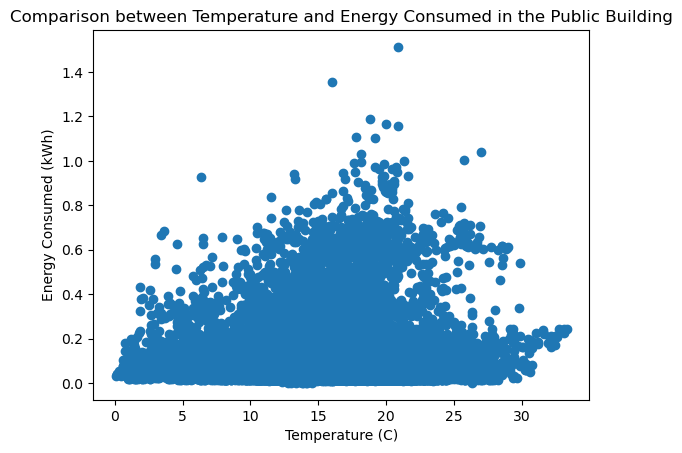

In [5]:
plt.scatter(df.Temp_Med[:35136], df.Energy[:35136])
plt.xlabel('Temperature (C)') 
plt.ylabel('Energy Consumed (kWh)')
plt.title('Comparison between Temperature and Energy Consumed in the Public Building')
plt.show()

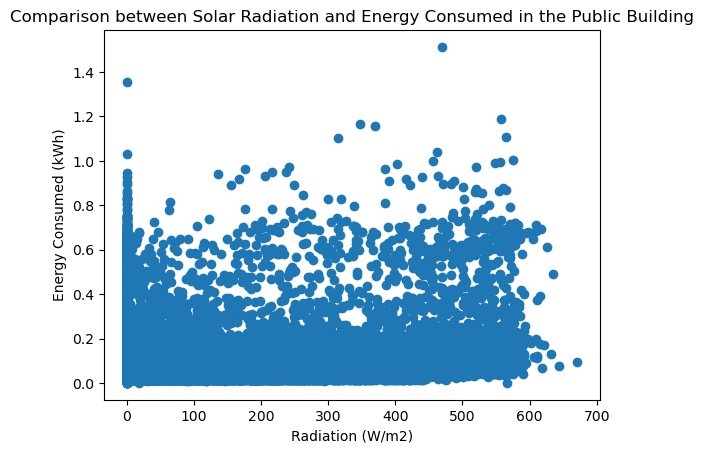

In [6]:
plt.scatter(df.Rad_Total[:35136], df.Energy[:35136])
plt.xlabel('Radiation (W/m2)') 
plt.ylabel('Energy Consumed (kWh)')
plt.title('Comparison between Solar Radiation and Energy Consumed in the Public Building')
plt.show()

### First Model (all weather features + last hour)

In [7]:
n_timesteps = 4
past = past_timesteps(df, n_timesteps)
X1, y1 = past.drop(["Time", "Location", "Energy"], axis=1), past.Energy
X1

100%|██████████| 4/4 [00:00<00:00, 36.89it/s]


,Temp_Med,Intensidade_Vento_Med,Precip,Rad_Total,Rumo_Vento_Corrected,lag_1,lag_2,lag_3,lag_4
0,16.40,1.30,0.00,0.0,5.0,0.132,0.122,0.070,0.068
1,16.35,2.05,0.00,0.0,5.0,0.125,0.132,0.122,0.070
2,16.40,2.50,0.00,0.0,4.0,0.089,0.125,0.132,0.122
3,16.50,2.25,0.00,0.0,4.0,0.112,0.089,0.125,0.132
4,16.50,2.00,0.00,0.0,4.0,0.111,0.112,0.089,0.125
...,...,...,...,...,...,...,...,...,...
1520115,16.40,2.50,0.00,0.0,1.0,0.010,0.009,0.032,0.039
1520116,16.40,2.05,0.05,0.0,8.0,0.009,0.010,0.009,0.032
1520117,16.50,1.80,0.10,0.3,8.0,0.009,0.009,0.010,0.009
1520118,16.50,2.20,0.05,0.0,1.0,0.040,0.009,0.009,0.010


In [8]:
pd.DataFrame(y1)

,Energy
0,0.125
1,0.089
2,0.112
3,0.111
4,0.091
...,...
1520115,0.009
1520116,0.009
1520117,0.040
1520118,0.038


### Second Model (all weather features + last 24 hours)
##### Since the data is in intervals of 15 minutes, it will add 24 * 4 = 96 new features

In [9]:
n_timesteps = 96
past = past_timesteps(df, n_timesteps)
X2, y2 = past.drop(["Time", "Location", "Energy"], axis=1), past.Energy
X2

 30%|███       | 29/96 [00:00<00:01, 43.32it/s]

100%|██████████| 96/96 [00:02<00:00, 43.52it/s]


,Temp_Med,Intensidade_Vento_Med,Precip,Rad_Total,Rumo_Vento_Corrected,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_87,lag_88,lag_89,lag_90,lag_91,lag_92,lag_93,lag_94,lag_95,lag_96
0,18.90,5.00,0.00,215.90,8.0,0.086,0.041,0.061,0.637,0.329,...,0.156,0.091,0.111,0.112,0.089,0.125,0.132,0.122,0.070,0.068
1,18.90,4.70,0.00,246.85,8.0,0.057,0.086,0.041,0.061,0.637,...,0.377,0.156,0.091,0.111,0.112,0.089,0.125,0.132,0.122,0.070
2,18.90,5.00,0.00,132.30,8.0,0.065,0.057,0.086,0.041,0.061,...,0.089,0.377,0.156,0.091,0.111,0.112,0.089,0.125,0.132,0.122
3,19.05,5.00,0.00,247.75,8.0,0.030,0.065,0.057,0.086,0.041,...,0.096,0.089,0.377,0.156,0.091,0.111,0.112,0.089,0.125,0.132
4,19.00,4.60,0.00,152.00,8.0,0.329,0.030,0.065,0.057,0.086,...,0.093,0.096,0.089,0.377,0.156,0.091,0.111,0.112,0.089,0.125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505395,16.40,2.50,0.00,0.00,1.0,0.010,0.009,0.032,0.039,0.037,...,0.038,0.042,0.014,0.010,0.009,0.010,0.022,0.038,0.041,0.015
1505396,16.40,2.05,0.05,0.00,8.0,0.009,0.010,0.009,0.032,0.039,...,0.020,0.038,0.042,0.014,0.010,0.009,0.010,0.022,0.038,0.041
1505397,16.50,1.80,0.10,0.30,8.0,0.009,0.009,0.010,0.009,0.032,...,0.010,0.020,0.038,0.042,0.014,0.010,0.009,0.010,0.022,0.038
1505398,16.50,2.20,0.05,0.00,1.0,0.040,0.009,0.009,0.010,0.009,...,0.009,0.010,0.020,0.038,0.042,0.014,0.010,0.009,0.010,0.022


In [10]:
pd.DataFrame(y2)

,Energy
0,0.057
1,0.065
2,0.030
3,0.329
4,0.329
...,...
1505395,0.009
1505396,0.009
1505397,0.040
1505398,0.038


### Third Model (all weather features + last 7 days at exact same time)
##### Multiply i by 96 to skip a day

In [11]:
features_7 = df.sort_values(by=['Location', 'Time'])
for i in range(1, 8):
    features_7.loc[features_7['Time'].shift(i*96) == features_7['Time'] - pd.Timedelta(i, 'day'), f"lag_{i*96}"] = features_7['Energy'].shift(i*96)
features_7.dropna(inplace=True)
features_7.reset_index(drop=True, inplace=True)
features_7

,Time,Location,Temp_Med,Intensidade_Vento_Med,Precip,Rad_Total,Energy,Rumo_Vento_Corrected,lag_96,lag_192,lag_288,lag_384,lag_480,lag_576,lag_672
0,2022-05-12 12:00:00,Energy_1,20.6,6.30,0.00,339.70,0.039,1.0,0.041,0.023,0.044,0.033,0.032,0.057,0.068
1,2022-05-12 12:15:00,Energy_1,20.2,6.65,0.00,290.20,0.061,1.0,0.487,0.034,0.058,0.034,0.029,0.065,0.070
2,2022-05-12 12:30:00,Energy_1,20.1,6.40,0.00,289.70,0.038,1.0,0.340,0.037,0.038,0.055,0.047,0.030,0.122
3,2022-05-12 12:45:00,Energy_1,20.0,6.40,0.00,263.95,0.069,5.0,0.058,0.046,0.026,0.058,0.022,0.329,0.132
4,2022-05-12 13:00:00,Energy_1,20.2,5.90,0.00,234.60,0.063,1.0,0.044,0.024,0.026,0.036,0.020,0.329,0.125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413235,2023-06-07 01:15:00,Energy_96,16.4,2.50,0.00,0.00,0.009,1.0,0.015,0.041,0.032,0.009,0.010,0.010,0.023
1413236,2023-06-07 01:30:00,Energy_96,16.4,2.05,0.05,0.00,0.009,8.0,0.041,0.037,0.009,0.010,0.009,0.036,0.010
1413237,2023-06-07 01:45:00,Energy_96,16.5,1.80,0.10,0.30,0.040,8.0,0.038,0.016,0.010,0.009,0.020,0.039,0.009
1413238,2023-06-07 02:00:00,Energy_96,16.5,2.20,0.05,0.00,0.038,1.0,0.022,0.010,0.009,0.009,0.041,0.029,0.010


In [12]:
X3, y3 = features_7.drop(["Time", "Location", "Energy"], axis=1), features_7.Energy
X3

,Temp_Med,Intensidade_Vento_Med,Precip,Rad_Total,Rumo_Vento_Corrected,lag_96,lag_192,lag_288,lag_384,lag_480,lag_576,lag_672
0,20.6,6.30,0.00,339.70,1.0,0.041,0.023,0.044,0.033,0.032,0.057,0.068
1,20.2,6.65,0.00,290.20,1.0,0.487,0.034,0.058,0.034,0.029,0.065,0.070
2,20.1,6.40,0.00,289.70,1.0,0.340,0.037,0.038,0.055,0.047,0.030,0.122
3,20.0,6.40,0.00,263.95,5.0,0.058,0.046,0.026,0.058,0.022,0.329,0.132
4,20.2,5.90,0.00,234.60,1.0,0.044,0.024,0.026,0.036,0.020,0.329,0.125
...,...,...,...,...,...,...,...,...,...,...,...,...
1413235,16.4,2.50,0.00,0.00,1.0,0.015,0.041,0.032,0.009,0.010,0.010,0.023
1413236,16.4,2.05,0.05,0.00,8.0,0.041,0.037,0.009,0.010,0.009,0.036,0.010
1413237,16.5,1.80,0.10,0.30,8.0,0.038,0.016,0.010,0.009,0.020,0.039,0.009
1413238,16.5,2.20,0.05,0.00,1.0,0.022,0.010,0.009,0.009,0.041,0.029,0.010


In [13]:
pd.DataFrame(y3)

,Energy
0,0.039
1,0.061
2,0.038
3,0.069
4,0.063
...,...
1413235,0.009
1413236,0.009
1413237,0.040
1413238,0.038


### Fourth Model (last hour + last 7 days at exact same time + DayOfWeek + Hour)

In [14]:
features_7 = df.sort_values(by=['Location', 'Time'])
for i in range(1, 5):
    features_7.loc[features_7['Time'].shift(i) == features_7['Time'] - pd.Timedelta(i*15, 'm'), f"lag_{i}"] = features_7['Energy'].shift(i)
for i in range(1, 8):
    features_7.loc[features_7['Time'].shift(i*96) == features_7['Time'] - pd.Timedelta(i, 'day'), f"lag_{i*96}"] = features_7['Energy'].shift(i*96)
features_7.dropna(inplace=True)
features_7.reset_index(drop=True, inplace=True)
features_7

,Time,Location,Temp_Med,Intensidade_Vento_Med,Precip,Rad_Total,Energy,Rumo_Vento_Corrected,lag_1,lag_2,lag_3,lag_4,lag_96,lag_192,lag_288,lag_384,lag_480,lag_576,lag_672
0,2022-05-12 12:00:00,Energy_1,20.6,6.30,0.00,339.70,0.039,1.0,0.016,0.058,0.038,0.022,0.041,0.023,0.044,0.033,0.032,0.057,0.068
1,2022-05-12 12:15:00,Energy_1,20.2,6.65,0.00,290.20,0.061,1.0,0.039,0.016,0.058,0.038,0.487,0.034,0.058,0.034,0.029,0.065,0.070
2,2022-05-12 12:30:00,Energy_1,20.1,6.40,0.00,289.70,0.038,1.0,0.061,0.039,0.016,0.058,0.340,0.037,0.038,0.055,0.047,0.030,0.122
3,2022-05-12 12:45:00,Energy_1,20.0,6.40,0.00,263.95,0.069,5.0,0.038,0.061,0.039,0.016,0.058,0.046,0.026,0.058,0.022,0.329,0.132
4,2022-05-12 13:00:00,Energy_1,20.2,5.90,0.00,234.60,0.063,1.0,0.069,0.038,0.061,0.039,0.044,0.024,0.026,0.036,0.020,0.329,0.125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413235,2023-06-07 01:15:00,Energy_96,16.4,2.50,0.00,0.00,0.009,1.0,0.010,0.009,0.032,0.039,0.015,0.041,0.032,0.009,0.010,0.010,0.023
1413236,2023-06-07 01:30:00,Energy_96,16.4,2.05,0.05,0.00,0.009,8.0,0.009,0.010,0.009,0.032,0.041,0.037,0.009,0.010,0.009,0.036,0.010
1413237,2023-06-07 01:45:00,Energy_96,16.5,1.80,0.10,0.30,0.040,8.0,0.009,0.009,0.010,0.009,0.038,0.016,0.010,0.009,0.020,0.039,0.009
1413238,2023-06-07 02:00:00,Energy_96,16.5,2.20,0.05,0.00,0.038,1.0,0.040,0.009,0.009,0.010,0.022,0.010,0.009,0.009,0.041,0.029,0.010


In [15]:
X4 = features_7.drop(weather_cols, axis=1)
X4["DayOfWeek"] = past.Time.dt.dayofweek
X4["Hour"] = past.Time.dt.hour
X4.drop(["Time", "Location", "Energy"], axis=1, inplace=True)
y4 = y3
X4

,lag_1,lag_2,lag_3,lag_4,lag_96,lag_192,lag_288,lag_384,lag_480,lag_576,lag_672,DayOfWeek,Hour
0,0.016,0.058,0.038,0.022,0.041,0.023,0.044,0.033,0.032,0.057,0.068,4,12
1,0.039,0.016,0.058,0.038,0.487,0.034,0.058,0.034,0.029,0.065,0.070,4,12
2,0.061,0.039,0.016,0.058,0.340,0.037,0.038,0.055,0.047,0.030,0.122,4,12
3,0.038,0.061,0.039,0.016,0.058,0.046,0.026,0.058,0.022,0.329,0.132,4,12
4,0.069,0.038,0.061,0.039,0.044,0.024,0.026,0.036,0.020,0.329,0.125,4,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413235,0.010,0.009,0.032,0.039,0.015,0.041,0.032,0.009,0.010,0.010,0.023,0,2
1413236,0.009,0.010,0.009,0.032,0.041,0.037,0.009,0.010,0.009,0.036,0.010,0,2
1413237,0.009,0.009,0.010,0.009,0.038,0.016,0.010,0.009,0.020,0.039,0.009,0,2
1413238,0.040,0.009,0.009,0.010,0.022,0.010,0.009,0.009,0.041,0.029,0.010,0,2


In [16]:
y4

0          0.039
1          0.061
2          0.038
3          0.069
4          0.063
           ...  
1413235    0.009
1413236    0.009
1413237    0.040
1413238    0.038
1413239    0.038
Name: Energy, Length: 1413240, dtype: float64

### Fifth Model (last hour + DayOfWeek + Hour + Variation)

In [17]:
n_timesteps = 4
past_5th = past_timesteps(df, n_timesteps)
past_5th.drop(weather_cols, axis=1, inplace=True)
vari = add_energy_variation(past_5th)
X5 = past_5th.copy()
X5.drop(["Time", "Location", "Energy"], axis=1, inplace=True)
X5["DayOfWeek"] = past_5th.Time.dt.dayofweek
X5["Hour"] = past_5th.Time.dt.hour
y5 = past_5th.Energy
X5

100%|██████████| 4/4 [00:00<00:00, 39.07it/s]

,lag_1,lag_2,lag_3,lag_4,Variation,DayOfWeek,Hour
0,0.132,0.122,0.070,0.068,0.000000,3,13
1,0.125,0.132,0.122,0.070,0.000000,3,13
2,0.089,0.125,0.132,0.122,-0.288057,3,13
3,0.112,0.089,0.125,0.132,0.258286,3,13
4,0.111,0.112,0.089,0.125,-0.009017,3,14
...,...,...,...,...,...,...,...
1520115,0.010,0.009,0.032,0.039,0.109878,2,1
1520116,0.009,0.010,0.009,0.032,-0.100899,2,1
1520117,0.009,0.009,0.010,0.009,-0.001110,2,1
1520118,0.040,0.009,0.009,0.010,3.439512,2,2


In [18]:
pd.DataFrame(y5)

,Energy
0,0.125
1,0.089
2,0.112
3,0.111
4,0.091
...,...
1520115,0.009
1520116,0.009
1520117,0.040
1520118,0.038


### Sixth Model (last hour + last 7 days + DayOfWeek + Hour + Variation)

In [19]:
tmp = add_energy_variation(pd.DataFrame(y4))
X6 = X4.copy()
X6["Variation"] = tmp["Variation"]
y6 = y4.copy()
X6

,lag_1,lag_2,lag_3,lag_4,lag_96,lag_192,lag_288,lag_384,lag_480,lag_576,lag_672,DayOfWeek,Hour,Variation
0,0.016,0.058,0.038,0.022,0.041,0.023,0.044,0.033,0.032,0.057,0.068,4,12,0.000000
1,0.039,0.016,0.058,0.038,0.487,0.034,0.058,0.034,0.029,0.065,0.070,4,12,0.000000
2,0.061,0.039,0.016,0.058,0.340,0.037,0.038,0.055,0.047,0.030,0.122,4,12,0.563702
3,0.038,0.061,0.039,0.016,0.058,0.046,0.026,0.058,0.022,0.329,0.132,4,12,-0.377151
4,0.069,0.038,0.061,0.039,0.044,0.024,0.026,0.036,0.020,0.329,0.125,4,13,0.815312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413235,0.010,0.009,0.032,0.039,0.015,0.041,0.032,0.009,0.010,0.010,0.023,0,2,0.109878
1413236,0.009,0.010,0.009,0.032,0.041,0.037,0.009,0.010,0.009,0.036,0.010,0,2,-0.100899
1413237,0.009,0.009,0.010,0.009,0.038,0.016,0.010,0.009,0.020,0.039,0.009,0,2,-0.001110
1413238,0.040,0.009,0.009,0.010,0.022,0.010,0.009,0.009,0.041,0.029,0.010,0,2,3.439512


In [20]:
y6

0          0.039
1          0.061
2          0.038
3          0.069
4          0.063
           ...  
1413235    0.009
1413236    0.009
1413237    0.040
1413238    0.038
1413239    0.038
Name: Energy, Length: 1413240, dtype: float64

## Train and Predict Models

In [21]:
# First Model (all weather features)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
model1, preds1 = build_model(xgb.XGBRegressor(seed=0, tree_method='gpu_hist'), X1_train, y1_train, X1_test)

# Second Model (weather features + last 24 hours)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)
model2, preds2 = build_model(xgb.XGBRegressor(seed=0, tree_method='gpu_hist'), X2_train, y2_train, X2_test)

# Third Model (weather features + last 7 days at the exact same time)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)
model3, preds3 = build_model(xgb.XGBRegressor(seed=0, tree_method='gpu_hist'), X3_train, y3_train, X3_test)

# Fourth Model (last hour + last 7 days at exact same time + DayOfWeek + Hour))
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=42)
model4, preds4 = build_model(xgb.XGBRegressor(seed=0, tree_method='gpu_hist'), X4_train, y4_train, X4_test)

# Fifth Model (last hour + DayOfWeek + Hour + Variation)
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.2, random_state=42)
model5, preds5 = build_model(xgb.XGBRegressor(seed=0, tree_method='gpu_hist'), X5_train, y5_train, X5_test)

# Sixth Model (last hour + last 7 days + DayOfWeek + Hour + Variation)
X6_train, X6_test, y6_train, y6_test = train_test_split(X6, y6, test_size=0.2, random_state=42)
model6, preds6 = build_model(xgb.XGBRegressor(seed=0, tree_method='gpu_hist'), X6_train, y6_train, X6_test)

## Plot Models and Show Performance Metrics

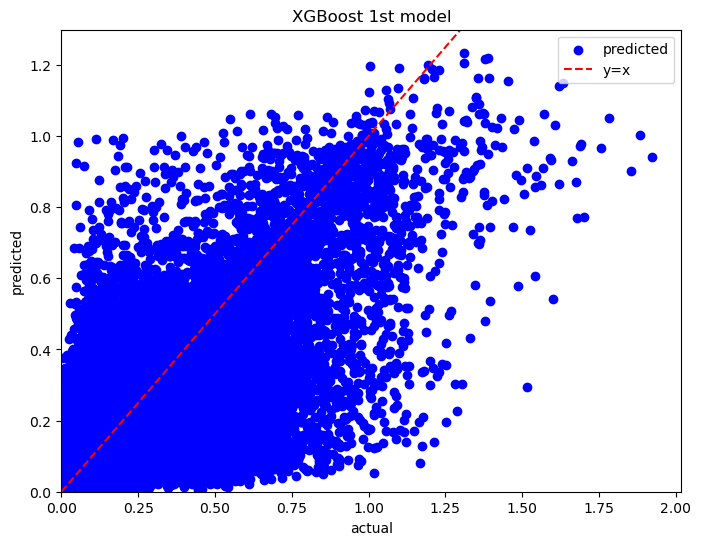

In [22]:
plt.figure(figsize=(8, 6))

plot_results(preds1, y1_test, 'XGBoost 1st model')

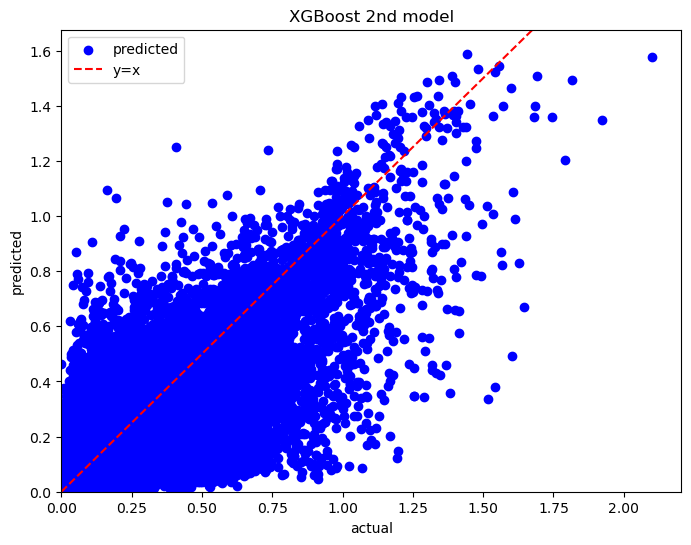

In [23]:
plt.figure(figsize=(8, 6))

plot_results(preds2, y2_test, 'XGBoost 2nd model')

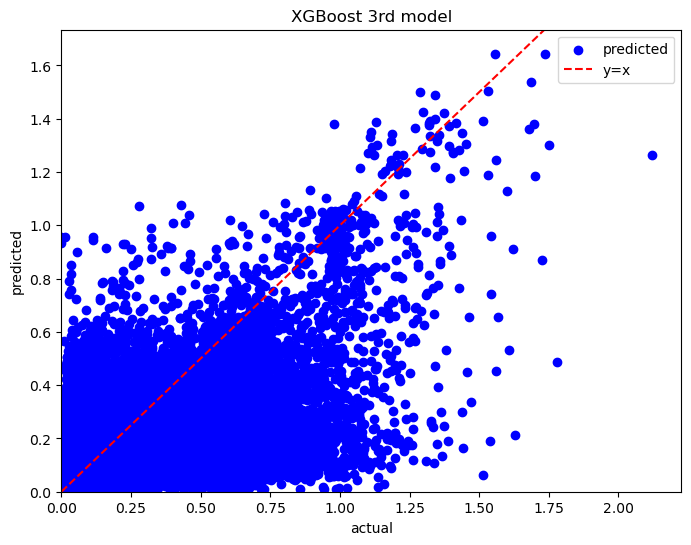

In [24]:
plt.figure(figsize=(8, 6))

plot_results(preds3, y3_test, 'XGBoost 3rd model')

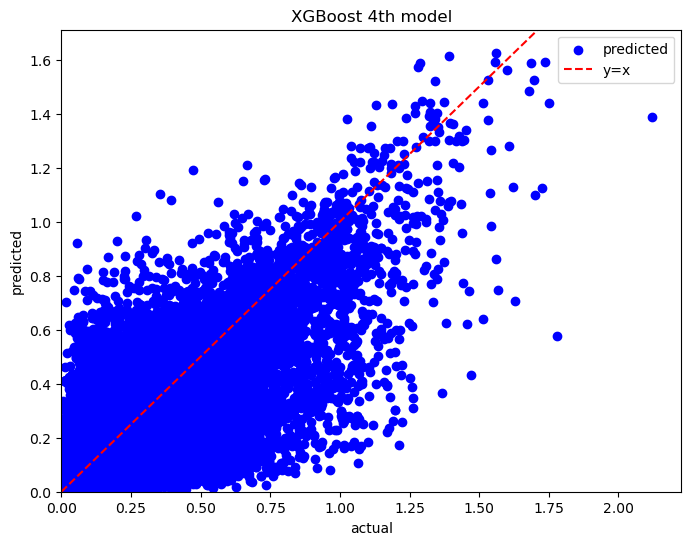

In [25]:
plt.figure(figsize=(8, 6))

plot_results(preds4, y4_test, 'XGBoost 4th model')

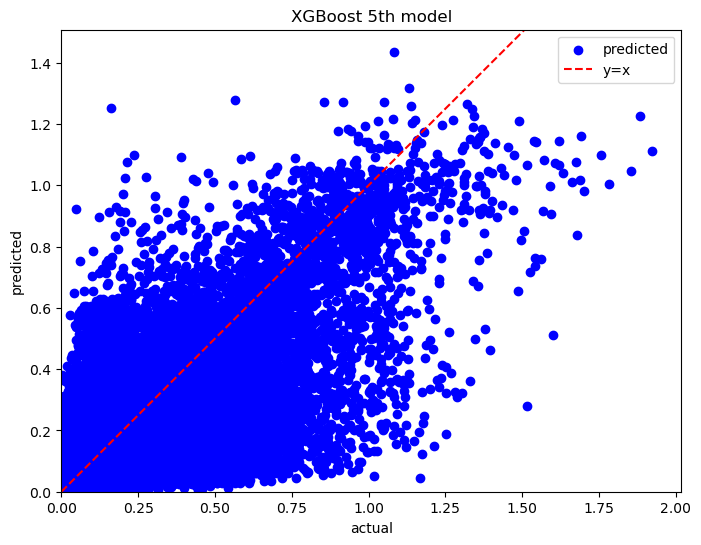

In [26]:
plt.figure(figsize=(8, 6))

plot_results(preds5, y5_test, 'XGBoost 5th model')

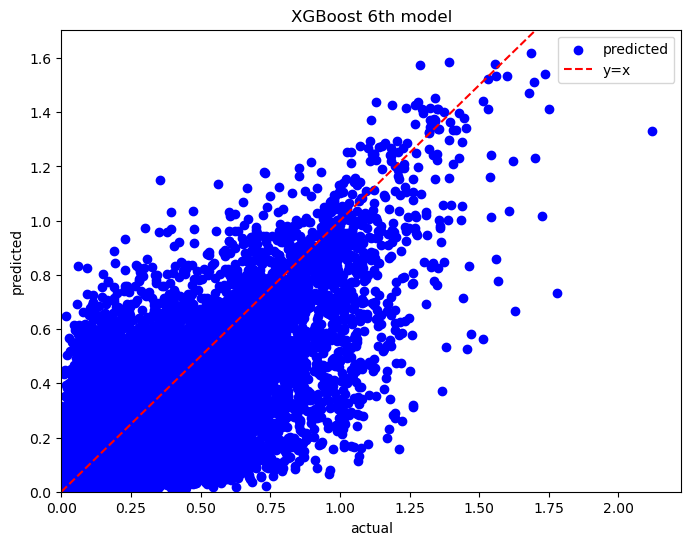

In [27]:
plt.figure(figsize=(8, 6))

plot_results(preds6, y6_test, 'XGBoost 6th model')

In [28]:
print("First Model")
performance_metrics(preds1, y1_test.values.reshape(-1))
print()
print("Second Model")
performance_metrics(preds2, y2_test.values.reshape(-1))
print()
print("Third Model")
performance_metrics(preds3, y3_test.values.reshape(-1))

First Model
MSE: 0.0043
RMSE: 0.0661
WAPE: 34.98
R2: 0.6898

Second Model
MSE: 0.0040
RMSE: 0.0634
WAPE: 34.29
R2: 0.7152

Third Model
MSE: 0.0080
RMSE: 0.0899
WAPE: 53.04
R2: 0.4333


(0.008, 53.04, 0.4333)

In [29]:
print("Fourth Model")
performance_metrics(preds4, y4_test.values.reshape(-1))
print()
print("Fifth Model")
performance_metrics(preds5, y5_test.values.reshape(-1))
print()
print("Sixth Model")
performance_metrics(preds6, y6_test.values.reshape(-1))

Fourth Model
MSE: 0.0039
RMSE: 0.0632
WAPE: 34.11
R2: 0.7203

Fifth Model
MSE: 0.0042
RMSE: 0.0650
WAPE: 34.58
R2: 0.6998

Sixth Model
MSE: 0.0039
RMSE: 0.0630
WAPE: 33.99
R2: 0.7219


(0.0039, 33.989999999999995, 0.7219)

## Cross Validation

In [30]:
def cv_validate(classifier, X, y, k):
    scores = cross_validate(classifier, X, y, cv=KFold(n_splits=k, shuffle=True),scoring='r2', return_estimator=True)
    print("R2 score: %0.2f +- %0.2f" % (scores['test_score'].mean(), scores['test_score'].std()))
    return scores

In [31]:
scores1 = cv_validate(xgb.XGBRegressor(seed=42, tree_method="gpu_hist"), X1_train, y1_train, 5)

R2 score: 0.69 +- 0.00


In [32]:
scores2 = cv_validate(xgb.XGBRegressor(seed=42, tree_method="gpu_hist"), X2_train, y2_train, 5)

R2 score: 0.72 +- 0.00


In [33]:
scores3 = cv_validate(xgb.XGBRegressor(seed=42, tree_method="gpu_hist"), X3_train, y3_train, 5)

R2 score: 0.43 +- 0.00


In [34]:
scores4 = cv_validate(xgb.XGBRegressor(seed=42, tree_method="gpu_hist"), X4_train, y4_train, 5)

R2 score: 0.72 +- 0.00


In [35]:
scores5 = cv_validate(xgb.XGBRegressor(seed=42, tree_method="gpu_hist"), X5_train, y5_train, 5)

R2 score: 0.70 +- 0.00


In [36]:
scores6 = cv_validate(xgb.XGBRegressor(seed=42, tree_method="gpu_hist"), X6_train, y6_train, 5)

R2 score: 0.72 +- 0.00


In [37]:
scores1['test_score'], scores2['test_score'], scores3['test_score'], scores4['test_score'], scores5['test_score'], scores6['test_score']

(array([0.68923353, 0.68713021, 0.68627461, 0.68822995, 0.68871469]),
 array([0.71257897, 0.71944436, 0.72042979, 0.72099219, 0.71731034]),
 array([0.43053815, 0.43941422, 0.43519005, 0.4325537 , 0.4370622 ]),
 array([0.72062907, 0.7154079 , 0.72483496, 0.71493698, 0.71864948]),
 array([0.69030759, 0.69817795, 0.69695347, 0.70442556, 0.69735496]),
 array([0.71995445, 0.72222503, 0.72151482, 0.7209358 , 0.71839061]))

## Feature Importance

In [38]:
model1.feature_importances_

array([0.00881823, 0.00704527, 0.00439288, 0.01115695, 0.00963146,
       0.9028926 , 0.02259918, 0.01958309, 0.01388039], dtype=float32)

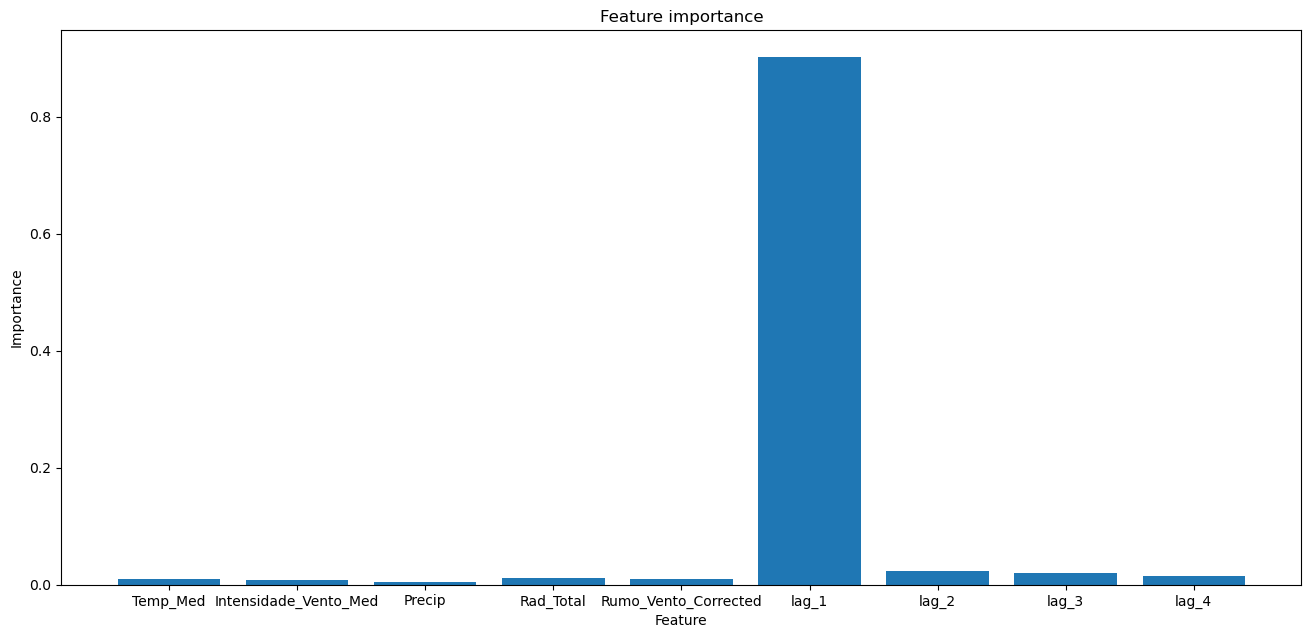

In [39]:
time_importance = model1.feature_importances_

plt.figure(figsize=(16, 7.2))
plt.bar(X1.columns, time_importance)
plt.title('Feature importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

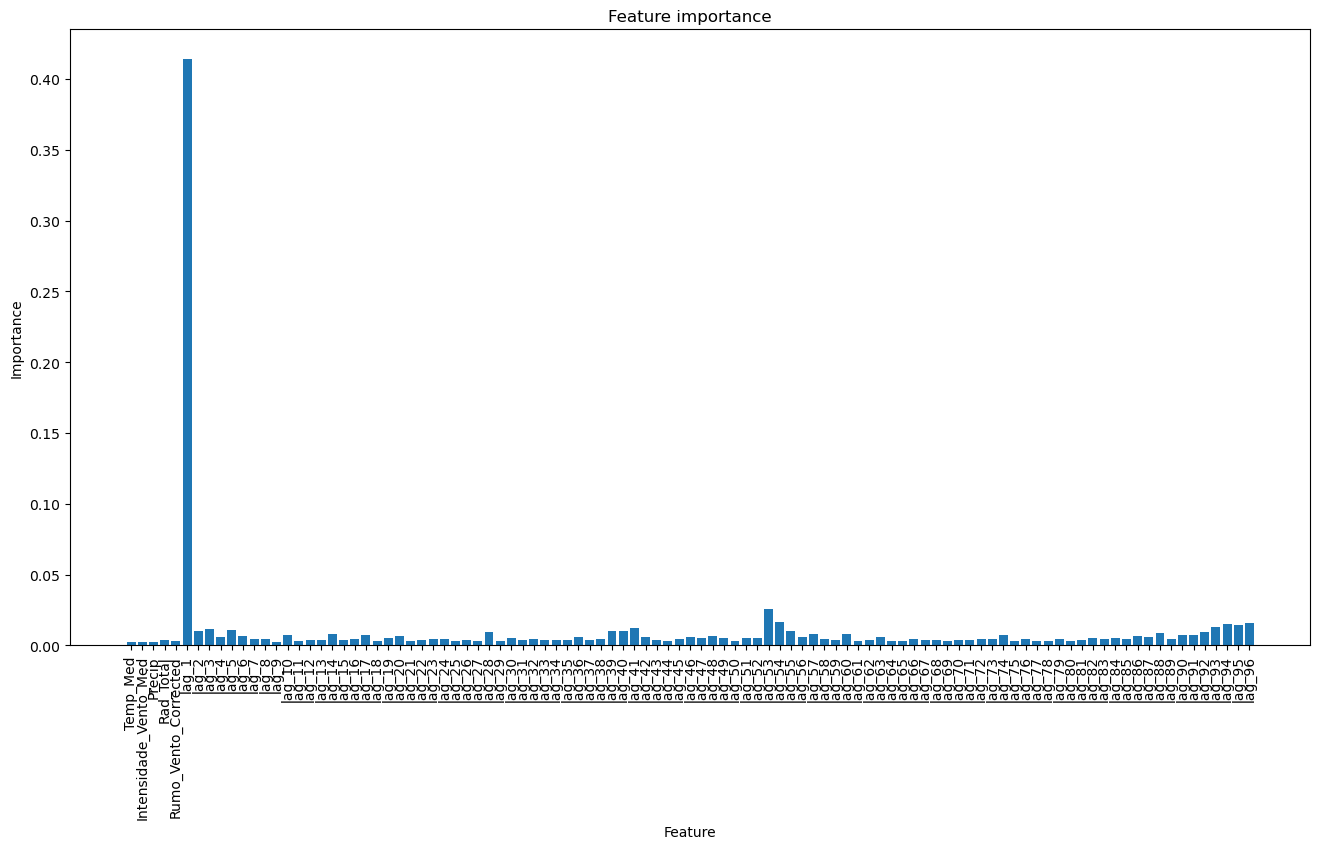

In [40]:
time_importance = model2.feature_importances_

plt.figure(figsize=(16, 8))
plt.bar(X2.columns, time_importance)
plt.title('Feature importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

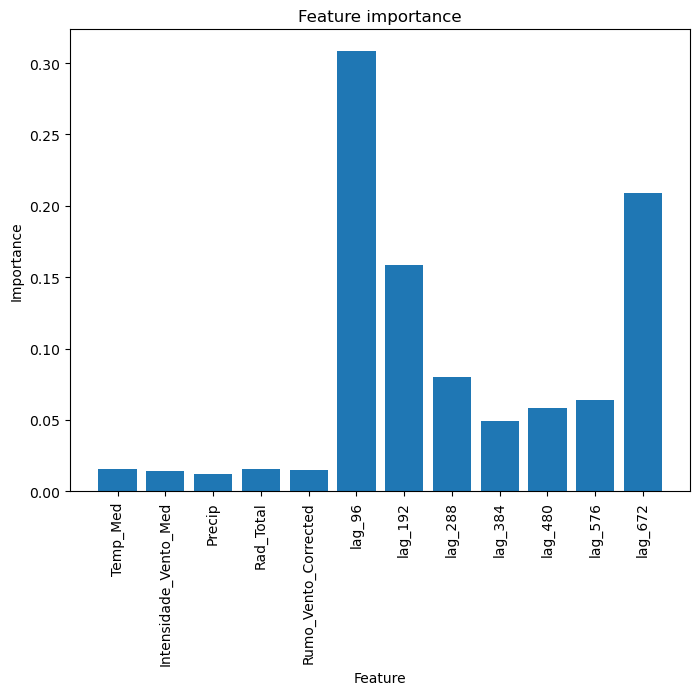

In [41]:
time_importance = model3.feature_importances_

plt.figure(figsize=(8, 6))
plt.bar(X3.columns, time_importance)
plt.title('Feature importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

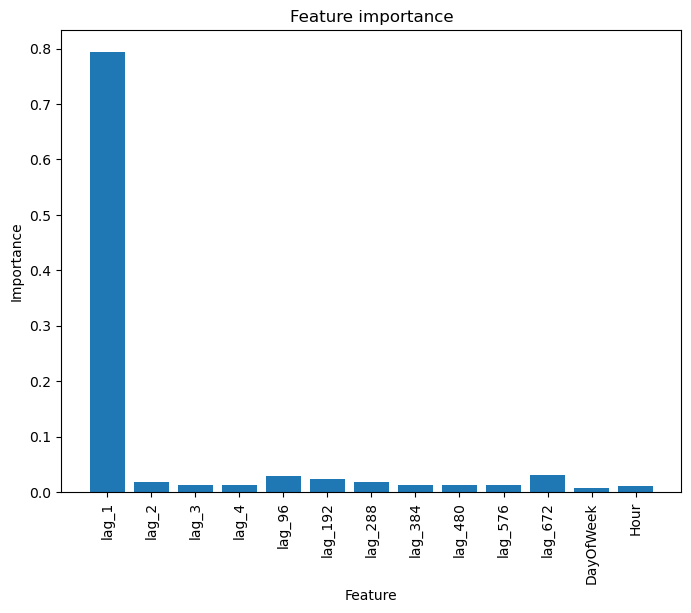

In [42]:
time_importance = model4.feature_importances_

plt.figure(figsize=(8, 6))
plt.bar(X4.columns, time_importance)
plt.title('Feature importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

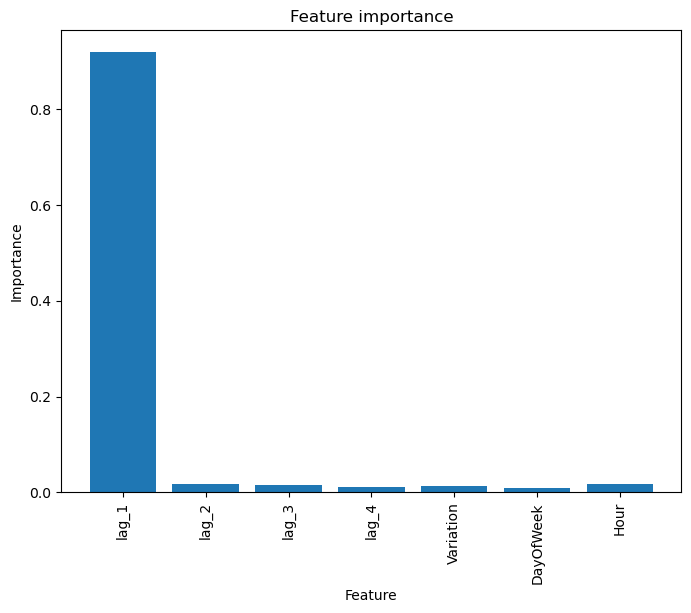

In [43]:
time_importance = model5.feature_importances_

plt.figure(figsize=(8, 6))
plt.bar(X5.columns, time_importance)
plt.title('Feature importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

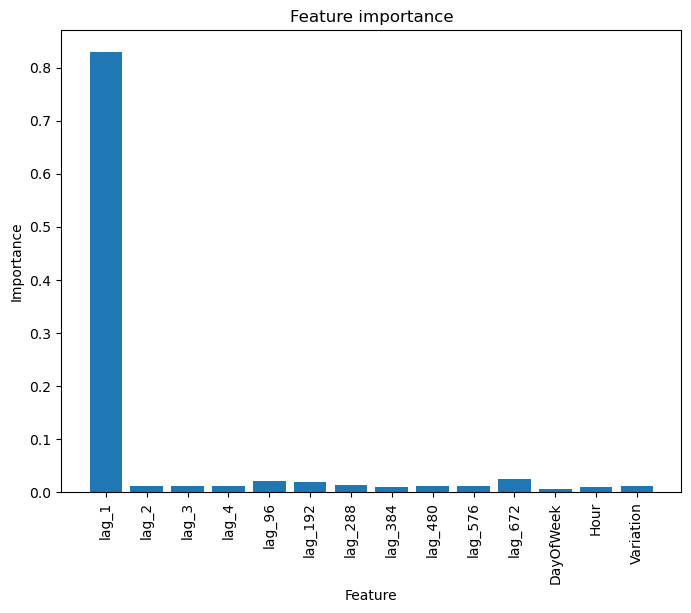

In [44]:
time_importance = model6.feature_importances_

plt.figure(figsize=(8, 6))
plt.bar(X6.columns, time_importance)
plt.title('Feature importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()